# UEFA Champion League Group Stages Accumulated Data From 1992-1993 Season To 2022-2023 Season

We scrape information of all group stages of UEFA Champion League, from 1992-1993 season to 2022-2023 season, from Wikipedia pages.

From example, one can find all information regarding 1992-1993 season from:
https://en.wikipedia.org/wiki/1992–93_UEFA_Champions_League.

In [183]:
url_prefix = "https://en.wikipedia.org/wiki/"
url_suffix = "_UEFA_Champions_League"

years_range = range(1992 , 2022)

url_array = []

for year in years_range:
    url_array.append(url_prefix + str(year) + "%E2%80%93" + str(year+1)[2:] + url_suffix)

url_array

['https://en.wikipedia.org/wiki/1992%E2%80%9393_UEFA_Champions_League',
 'https://en.wikipedia.org/wiki/1993%E2%80%9394_UEFA_Champions_League',
 'https://en.wikipedia.org/wiki/1994%E2%80%9395_UEFA_Champions_League',
 'https://en.wikipedia.org/wiki/1995%E2%80%9396_UEFA_Champions_League',
 'https://en.wikipedia.org/wiki/1996%E2%80%9397_UEFA_Champions_League',
 'https://en.wikipedia.org/wiki/1997%E2%80%9398_UEFA_Champions_League',
 'https://en.wikipedia.org/wiki/1998%E2%80%9399_UEFA_Champions_League',
 'https://en.wikipedia.org/wiki/1999%E2%80%9300_UEFA_Champions_League',
 'https://en.wikipedia.org/wiki/2000%E2%80%9301_UEFA_Champions_League',
 'https://en.wikipedia.org/wiki/2001%E2%80%9302_UEFA_Champions_League',
 'https://en.wikipedia.org/wiki/2002%E2%80%9303_UEFA_Champions_League',
 'https://en.wikipedia.org/wiki/2003%E2%80%9304_UEFA_Champions_League',
 'https://en.wikipedia.org/wiki/2004%E2%80%9305_UEFA_Champions_League',
 'https://en.wikipedia.org/wiki/2005%E2%80%9306_UEFA_Champions_L

We will use BeautifulSoup to scrape data from those wikipedia pages. References for using BeautifulSoup are:

https://stackoverflow.com/questions/3376803/beautifulsoup-find-th-with-text-price-then-get-price-from-next-th
https://stackoverflow.com/questions/68612714/web-scraping-all-text-between-tabletable-i-need-table-in-python
https://www.geeksforgeeks.org/how-to-find-a-html-tag-that-contains-certain-text-using-beautifulsoup/
https://stackoverflow.com/questions/24748445/beautiful-soup-using-regex-to-find-tags
https://www.geeksforgeeks.org/remove-all-style-scripts-and-html-tags-using-beautifulsoup/

In [184]:
import re
import pandas as pd
import requests
from bs4 import BeautifulSoup, NavigableString, Tag

We will assemble a data frame consisting of every group from all group stages. The columns name include the columns name from Wikipedia's tables, but we will also include team's association. For example, Milan belongs to the Italian Football Federation.

In [185]:
columns=["Association" , "Pos" , "Team" , "Pld" , "W" , "D" , "L" , "GF" , "GA" , "GD" , "Pts"] 

df_all_group_stages = pd.DataFrame(columns = columns)
df_all_group_stages

,Association,Pos,Team,Pld,W,D,L,GF,GA,GD,Pts


From each url, for example https://en.wikipedia.org/wiki/1992–93_UEFA_Champions_League, we use BeautifulSoup to get the raw html for all groups.

In [186]:
def all_groups_in_a_season_redundant_html( year ):
    group_stage_redundant = BeautifulSoup(requests.get( url_array[year - 1992] ).content, "html.parser")
    
    all_groups_in_a_season_redundant = group_stage_redundant.find_all(lambda tag: tag.name == "th" and "Pld" in tag.text)
    
    all_groups_in_a_season_redundant = [x.parent.parent for x in all_groups_in_a_season_redundant]
    
    all_groups_in_a_season_redundant = list ( filter ( lambda x: len(x.find_all(lambda tag: tag.name =="abbr" and "Grp" in tag.text)) ==0 , all_groups_in_a_season_redundant ) )   
    
    return all_groups_in_a_season_redundant

We clean up the messy html to make data more accessible.

In [187]:
def a_group_in_a_season_cleaned_html(a_group_in_a_season_redundant_html):
    for abbr_title in a_group_in_a_season_redundant_html.find_all('abbr'):
        abbr_title.parent.decompose()

    for style_tag in a_group_in_a_season_redundant_html(['style']):
        style_tag.decompose()
    
    a_group_in_a_season_redundant_html.find_all(lambda tag:tag.name=="th" and "Team" in tag.text)[0].parent.decompose()
    
    for qualification_th in a_group_in_a_season_redundant_html.find_all(lambda tag: tag.name == "th" and "Qualification" in tag.text):
        qualification_th.decompose()
    
    for advance_to_td in a_group_in_a_season_redundant_html.find_all(lambda tag: tag.name == "td" and "Advance to" in tag.text):
        advance_to_td.decompose()
    
    for transfer_to_td in a_group_in_a_season_redundant_html.find_all(lambda tag: tag.name == "td" and "Transfer to" in tag.text):
        transfer_to_td.decompose()
        
    for head_to_head_td in a_group_in_a_season_redundant_html.find_all(lambda tag: tag.name == "td" and "—" in tag.text):
        head_to_head_td.decompose()
    
    for head_to_head_td in a_group_in_a_season_redundant_html.find_all('a', {'href': re.compile('group_stage#.*v_')}):
        head_to_head_td.parent.decompose()
    
    for empty_tds in a_group_in_a_season_redundant_html.find_all("td"):
        if empty_tds.text.strip() == "":
            empty_tds.decompose()
            
    for abbr in a_group_in_a_season_redundant_html.find_all('th', {'scope': "col"}):
        if len(abbr.find_all("span")) >0:
            abbr.decompose()

    for empty_ths in a_group_in_a_season_redundant_html.find_all("th"):
        if empty_ths.text.strip() == "":
            empty_ths.decompose()
    
    return a_group_in_a_season_redundant_html

We assemble the cleaned html for the table into a dataframe.

In [188]:
def a_group_html_to_dataframe(a_group_in_a_season_cleaned_html , which_group , which_year):
    all_data = []

    for tr in a_group_in_a_season_cleaned_html:
        if isinstance(tr, NavigableString):
            continue
        if isinstance(tr, Tag):
            association = tr.find("span").find("a")["title"]
            th = tr.find("th")
            th.name = "td"
            tds = [association] + [td.get_text(strip=True) for td in tr.select("td")]
            all_data.append(tds)

    df = pd.DataFrame(all_data , columns=columns)

    df["Season"] = [str(which_year) + "–" + str(which_year+1)[2:] ] * 4
    df["Group"] = [chr(ord('@')+ which_group + 1)] * 4

    df = df[["Season", "Group"] + columns]
    return df

For example, let's look at group A of season 1992-1993.

In [189]:
a_group_html_to_dataframe( a_group_in_a_season_cleaned_html( all_groups_in_a_season_redundant_html( 1992 )[0] ) , 0 , 1992 )

,Season,Group,Association,Pos,Team,Pld,W,D,L,GF,GA,GD,Pts
0,1992–93,A,French Football Federation,1,Marseille,6,3,3,0,14,4,+10,9
1,1992–93,A,Scottish Football Association,2,Rangers,6,2,4,0,7,5,+2,8
2,1992–93,A,Royal Belgian Football Association,3,Club Brugge,6,2,1,3,5,8,−3,5
3,1992–93,A,Russian Football Union,4,CSKA Moscow,6,0,2,4,2,11,−9,2


Now we can put all data into one dataframe.

In [190]:
for year in range(1992,2022):
    all_groups_in_that_season_redundant_html = all_groups_in_a_season_redundant_html( year )
    total_group_numbers = len(all_groups_in_that_season_redundant_html)
    for which_group in range( total_group_numbers ):
        this_group_cleaned_html = a_group_in_a_season_cleaned_html( all_groups_in_that_season_redundant_html[which_group] )
        df_all_group_stages = pd.concat([ df_all_group_stages , a_group_html_to_dataframe(this_group_cleaned_html , which_group , year ) ] , ignore_index = True )
         
df_all_group_stages.tail(50)

,Association,Pos,Team,Pld,W,D,L,GF,GA,GD,Pts,Season,Group
862,Royal Dutch Football Association,3,Ajax,6,2,1,3,7,7,0,7,2020–21,D
863,Danish Football Association,4,Midtjylland,6,0,2,4,4,13,−9,2,2020–21,D
864,The Football Association,1,Chelsea,6,4,2,0,14,2,+12,14,2020–21,E
865,Royal Spanish Football Federation,2,Sevilla,6,4,1,1,9,8,+1,13,2020–21,E
866,Russian Football Union,3,Krasnodar,6,1,2,3,6,11,−5,5,2020–21,E
867,French Football Federation,4,Rennes,6,0,1,5,3,11,−8,1,2020–21,E
868,German Football Association,1,Borussia Dortmund,6,4,1,1,12,5,+7,13,2020–21,F
869,Italian Football Federation,2,Lazio,6,2,4,0,11,7,+4,10,2020–21,F
870,Royal Belgian Football Association,3,Club Brugge,6,2,2,2,8,10,−2,8,2020–21,F
871,Russian Football Union,4,Zenit Saint Petersburg,6,0,1,5,4,13,−9,1,2020–21,F


We notice that there are rows with footer notes. We will delete those footers. We also convert strings into ints.

In [191]:
pd.concat([ df_all_group_stages[df_all_group_stages["Pts"].str.contains('\[a')] ,
        df_all_group_stages[df_all_group_stages["Pts"].str.contains('\[b')],
        df_all_group_stages[df_all_group_stages["Pts"].str.contains('\[c')] ] , ignore_index = True)

,Association,Pos,Team,Pld,W,D,L,GF,GA,GD,Pts,Season,Group
0,Italian Football Federation,2,Milan,6,3,1,2,6,5,+1,8[a],1994–95,D
1,Ukrainian Association of Football,2,Shakhtar Donetsk,6,3,1,2,12,8,+4,10[a],2012–13,E
2,The Football Association,3,Chelsea,6,3,1,2,16,10,+6,10[a],2012–13,E
3,France,1,Paris Saint-Germain,6,5,0,1,25,4,+21,15[a],2017–18,B
4,Germany,2,Bayern Munich,6,5,0,1,13,6,+7,15[a],2017–18,B
5,Italy,1,Roma,6,3,2,1,9,6,+3,11[a],2017–18,C
6,England,2,Chelsea,6,3,2,1,16,8,+8,11[a],2017–18,C
7,Germany,3,Borussia Dortmund,6,0,2,4,7,13,−6,2[a],2017–18,H
8,Cyprus,4,APOEL,6,0,2,4,2,17,−15,2[a],2017–18,H
9,Germany,1,Borussia Dortmund,6,4,1,1,10,2,+8,13[a],2018–19,A


In [192]:
for column in columns:
    df_all_group_stages[column] = df_all_group_stages[column].transform(lambda x : x[0 : x.find("[a")] if x.find("[a") >0 else x )
    df_all_group_stages[column] = df_all_group_stages[column].transform(lambda x : x[0 : x.find("[b")] if x.find("[b") >0 else x )

for column in ["Pld" , "W" , "D" , "L" , "GF" , "GA" , "GD" , "Pts"]:
    if column != "Pts" and column != "GD":
        df_all_group_stages[column] = df_all_group_stages[column].astype(int)
    else:
        df_all_group_stages[column] = df_all_group_stages[column].transform(lambda x : '-' + x[1:] if x.find("−") == 0 else x )
        df_all_group_stages[column] = df_all_group_stages[column].astype(int)
        
df_all_group_stages.tail(50)

,Association,Pos,Team,Pld,W,D,L,GF,GA,GD,Pts,Season,Group
862,Royal Dutch Football Association,3,Ajax,6,2,1,3,7,7,0,7,2020–21,D
863,Danish Football Association,4,Midtjylland,6,0,2,4,4,13,-9,2,2020–21,D
864,The Football Association,1,Chelsea,6,4,2,0,14,2,12,14,2020–21,E
865,Royal Spanish Football Federation,2,Sevilla,6,4,1,1,9,8,1,13,2020–21,E
866,Russian Football Union,3,Krasnodar,6,1,2,3,6,11,-5,5,2020–21,E
867,French Football Federation,4,Rennes,6,0,1,5,3,11,-8,1,2020–21,E
868,German Football Association,1,Borussia Dortmund,6,4,1,1,12,5,7,13,2020–21,F
869,Italian Football Federation,2,Lazio,6,2,4,0,11,7,4,10,2020–21,F
870,Royal Belgian Football Association,3,Club Brugge,6,2,2,2,8,10,-2,8,2020–21,F
871,Russian Football Union,4,Zenit Saint Petersburg,6,0,1,5,4,13,-9,1,2020–21,F


Another issue is that some countries' football association's name is incomplete. There is another issue that Football Association of Serbia and Montenegro splits into Football Association of Serbia.

In [193]:
sorted(df_all_group_stages["Association"].unique())

['Austrian Football Association',
 'Azerbaijan',
 'Belarus',
 'Belgium',
 'Bulgaria',
 'Bulgarian Football Union',
 'Croatia',
 'Croatian Football Federation',
 'Cyprus',
 'Cyprus Football Association',
 'Czech Republic',
 'Danish Football Association',
 'Denmark',
 'England',
 'Football Association of Finland',
 'Football Association of Serbia',
 'Football Association of Serbia and Montenegro',
 'Football Association of Slovenia',
 'Football Association of the Czech Republic',
 'Football Federation of Belarus',
 'France',
 'French Football Federation',
 'German Football Association',
 'Germany',
 'Greece',
 'Hellenic Football Federation',
 'Hungarian Football Federation',
 'Israel',
 'Israel Football Association',
 'Italian Football Federation',
 'Italy',
 'Kazakhstan',
 'Moldovan Football Federation',
 'Netherlands',
 'Norwegian Football Federation',
 'Poland',
 'Polish Football Association',
 'Portugal',
 'Portuguese Football Federation',
 'Romanian Football Federation',
 'Royal Bel

In [194]:
pd.concat ( [ df_all_group_stages[ df_all_group_stages["Association"]=='Serbia'] ,
df_all_group_stages[ df_all_group_stages["Association"]=='Football Association of Serbia'] ,
df_all_group_stages[ df_all_group_stages["Association"]=='Football Association of Serbia and Montenegro'] ] , ignore_index = True )
                    

,Association,Pos,Team,Pld,W,D,L,GF,GA,GD,Pts,Season,Group
0,Serbia,4,Red Star Belgrade,6,1,1,4,5,17,-12,4,2018–19,C
1,Football Association of Serbia,4,Partizan,6,0,0,6,2,13,-11,0,2010–11,H
2,Football Association of Serbia,4,Red Star Belgrade,6,1,0,5,3,20,-17,3,2019–20,B
3,Football Association of Serbia and Montenegro,4,Partizan,6,0,3,3,3,8,-5,3,2003–04,F


In [195]:
association_name_replacement = {
    'Azerbaijan': 'Association of Football Federations of Azerbaijan',
    'Belarus': 'Football Federation of Belarus',
    'Belgium': 'Royal Belgian Football Association',
    'Bulgaria': 'Bulgarian Football Union',
    'Croatia': 'Croatian Football Federation',
    'Cyprus': 'Cyprus Football Association',
    'Czech Republic': 'Football Association of the Czech Republic',
    'Denmark': 'Danish Football Association',
    'England': 'The Football Association',
    'France': 'French Football Federation',
    'Football Association of Serbia and Montenegro': 'Football Association of Serbia',
    'Germany': 'German Football Association',
    'Greece': 'Hellenic Football Federation',
    'Israel': 'Israel Football Association',
    'Italy': 'Italian Football Federation',
    'Kazakhstan': 'Kazakhstan Football Federation',
    'Netherlands': 'Royal Dutch Football Association',
    'Poland': 'Polish Football Association',
    'Portugal': 'Portuguese Football Federation',
    'Russia': 'Russian Football Union',
    'Scotland': 'Scottish Football Association',
    'Serbia': 'Football Association of Serbia',
    'Slovenia': 'Football Association of Slovenia',
    'Spain': 'Royal Spanish Football Federation',
    'Sweden':'Swedish Football Association',
    'Switzerland':'Swiss Football Association',
    'Turkey': 'Turkish Football Federation',
    'Ukraine': 'Ukrainian Association of Football'
}

df_all_group_stages["Association"] = df_all_group_stages["Association"].transform(lambda x : association_name_replacement[x] if x in association_name_replacement.keys() else x )

sorted(df_all_group_stages["Association"].unique())

['Association of Football Federations of Azerbaijan',
 'Austrian Football Association',
 'Bulgarian Football Union',
 'Croatian Football Federation',
 'Cyprus Football Association',
 'Danish Football Association',
 'Football Association of Finland',
 'Football Association of Serbia',
 'Football Association of Slovenia',
 'Football Association of the Czech Republic',
 'Football Federation of Belarus',
 'French Football Federation',
 'German Football Association',
 'Hellenic Football Federation',
 'Hungarian Football Federation',
 'Israel Football Association',
 'Italian Football Federation',
 'Kazakhstan Football Federation',
 'Moldovan Football Federation',
 'Norwegian Football Federation',
 'Polish Football Association',
 'Portuguese Football Federation',
 'Romanian Football Federation',
 'Royal Belgian Football Association',
 'Royal Dutch Football Association',
 'Royal Spanish Football Federation',
 'Russian Football Union',
 'Scottish Football Association',
 'Slovak Football Associa

Another issue is that team names also have duplicates, for example PSV and PSV Eindhoven, Inter Milan and Internazionale.

In [196]:
sorted( df_all_group_stages["Team"].unique() )

['1899 Hoffenheim',
 'AEK Athens',
 'AIK',
 'APOEL',
 'AZ',
 'AaB',
 'Aalborg BK',
 'Ajax',
 'Anderlecht',
 'Anorthosis',
 'Arsenal',
 'Artmedia',
 'Astana',
 'Atalanta',
 'Athletic Bilbao',
 'Atlético Madrid',
 'Austria Wien',
 'Auxerre',
 'BATE Borisov',
 'Barcelona',
 'Basel',
 'Bayer Leverkusen',
 'Bayern Munich',
 'Benfica',
 'Beşiktaş',
 'Blackburn Rovers',
 'Boavista',
 'Bordeaux',
 'Borussia Dortmund',
 'Borussia Mönchengladbach',
 'Braga',
 'Brøndby',
 'Bursaspor',
 'CFR Cluj',
 'CSKA Moscow',
 'Casino Salzburg',
 'Celta Vigo',
 'Celtic',
 'Chelsea',
 'Club Brugge',
 'Copenhagen',
 'Croatia Zagreb',
 'Debrecen',
 'Deportivo La Coruña',
 'Dinamo Zagreb',
 'Dynamo Kyiv',
 'Fenerbahçe',
 'Ferencváros',
 'Feyenoord',
 'Fiorentina',
 'Galatasaray',
 'Genk',
 'Gent',
 'Grasshopper',
 'HJK',
 'Hajduk Split',
 'Hamburg',
 'Hapoel Tel Aviv',
 'Heerenveen',
 'Helsingborg',
 'Hertha BSC',
 'IFK Göteborg',
 'Inter Milan',
 'Internazionale',
 'Juventus',
 'Kaiserslautern',
 'Košice',
 'Kra

In [197]:
team_name_replacement = {
    'PSV': 'PSV Eindhoven',
    'Internazionale': 'Inter Milan'
}

df_all_group_stages["Team"] = df_all_group_stages["Team"].transform(lambda x : team_name_replacement[x] if x in team_name_replacement.keys() else x )

sorted(df_all_group_stages["Team"].unique())

['1899 Hoffenheim',
 'AEK Athens',
 'AIK',
 'APOEL',
 'AZ',
 'AaB',
 'Aalborg BK',
 'Ajax',
 'Anderlecht',
 'Anorthosis',
 'Arsenal',
 'Artmedia',
 'Astana',
 'Atalanta',
 'Athletic Bilbao',
 'Atlético Madrid',
 'Austria Wien',
 'Auxerre',
 'BATE Borisov',
 'Barcelona',
 'Basel',
 'Bayer Leverkusen',
 'Bayern Munich',
 'Benfica',
 'Beşiktaş',
 'Blackburn Rovers',
 'Boavista',
 'Bordeaux',
 'Borussia Dortmund',
 'Borussia Mönchengladbach',
 'Braga',
 'Brøndby',
 'Bursaspor',
 'CFR Cluj',
 'CSKA Moscow',
 'Casino Salzburg',
 'Celta Vigo',
 'Celtic',
 'Chelsea',
 'Club Brugge',
 'Copenhagen',
 'Croatia Zagreb',
 'Debrecen',
 'Deportivo La Coruña',
 'Dinamo Zagreb',
 'Dynamo Kyiv',
 'Fenerbahçe',
 'Ferencváros',
 'Feyenoord',
 'Fiorentina',
 'Galatasaray',
 'Genk',
 'Gent',
 'Grasshopper',
 'HJK',
 'Hajduk Split',
 'Hamburg',
 'Hapoel Tel Aviv',
 'Heerenveen',
 'Helsingborg',
 'Hertha BSC',
 'IFK Göteborg',
 'Inter Milan',
 'Juventus',
 'Kaiserslautern',
 'Košice',
 'Krasnodar',
 'Lazio',


The data cleaning is now complete. We aggregate our data into dictionaries and visualize them.

In [198]:
individual_team_data = {
    "W": {},
    "D": {},
    "L": {},
    "GF": {},
    "GA": {},
    "GD": {},
    "Pts": {}
}

individual_association_data = {
    "W": {},
    "D": {},
    "L": {},
    "GF": {},
    "GA": {},
    "GD": {},
    "Pts": {}
}

for team in df_all_group_stages["Team"].unique():
    for column in ["W", "D", "L" , "GF" , "GA" , "GD" , "Pts"]:  
        individual_team_data[column][team] = df_all_group_stages[df_all_group_stages["Team"]== team][column].sum()

for association in df_all_group_stages["Association"].unique():
    for column in ["W", "D", "L" , "GF" , "GA" , "GD" , "Pts"]:  
        individual_association_data[column][association] = df_all_group_stages[df_all_group_stages["Association"]== association][column].sum()

In [199]:
individual_team_data_df = pd.DataFrame.from_dict(individual_team_data)

individual_team_data_df

,W,D,L,GF,GA,GD,Pts
Marseille,21,10,35,82,94,-12,70
Rangers,12,21,27,60,91,-31,55
Club Brugge,11,15,28,47,89,-42,46
CSKA Moscow,17,16,39,77,122,-45,67
Milan,54,35,31,170,113,57,189
...,...,...,...,...,...,...,...
Midtjylland,0,2,4,4,13,-9,2
Krasnodar,1,2,3,6,11,-5,5
Rennes,0,1,5,3,11,-8,1
İstanbul Başakşehir,1,0,5,7,18,-11,3


In [200]:
individual_association_data_df = pd.DataFrame.from_dict(individual_association_data)

individual_association_data_df

,W,D,L,GF,GA,GD,Pts
French Football Federation,182,102,160,667,552,115,645
Scottish Football Association,30,30,60,119,197,-78,118
Royal Belgian Football Association,28,47,93,139,312,-173,129
Russian Football Union,67,65,138,289,437,-148,266
Italian Football Federation,263,163,150,873,638,235,944
Swedish Football Association,13,5,36,44,117,-73,41
Portuguese Football Federation,133,75,134,435,443,-8,472
Royal Dutch Football Association,86,68,110,312,366,-54,326
Royal Spanish Football Federation,368,167,143,1232,697,535,1271
Turkish Football Federation,49,47,114,193,376,-183,194


Let's look at a bar chart representing the top 10 associations by total wins.

In [201]:
import matplotlib.pyplot as plt

df_bar_chart = individual_association_data_df.sort_values("W",ascending = False)

df_bar_chart

,W,D,L,GF,GA,GD,Pts
Royal Spanish Football Federation,368,167,143,1232,697,535,1271
The Football Association,347,152,143,1177,636,541,1193
German Football Association,264,125,169,956,716,240,917
Italian Football Federation,263,163,150,873,638,235,944
French Football Federation,182,102,160,667,552,115,645
Portuguese Football Federation,133,75,134,435,443,-8,472
Royal Dutch Football Association,86,68,110,312,366,-54,326
Russian Football Union,67,65,138,289,437,-148,266
Ukrainian Association of Football,62,46,102,260,335,-75,232
Hellenic Football Federation,61,48,107,229,350,-121,231


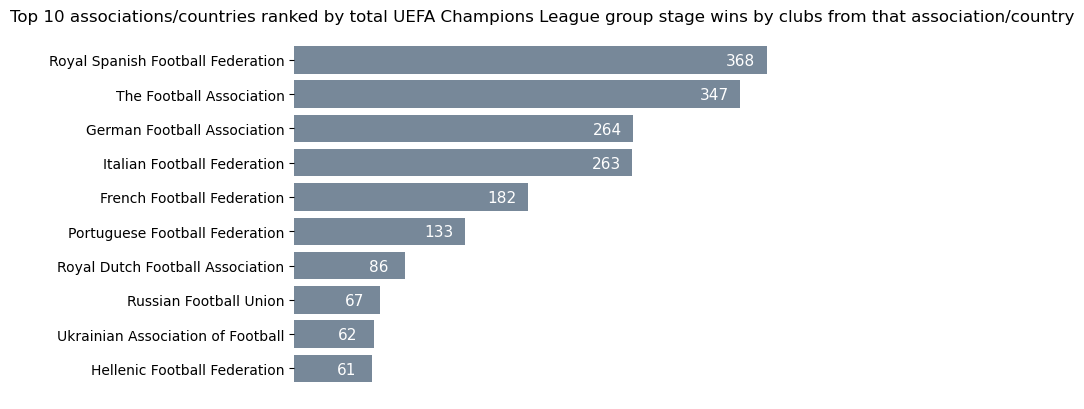

In [202]:
bars = plt.barh( df_bar_chart.index.tolist() [9::-1] , df_bar_chart["W"].values[9::-1], align='center', linewidth=0, color='lightslategrey'  )

plt.xticks([])
plt.title("Top 10 associations/countries ranked by total UEFA Champions League group stage wins by clubs from that association/country")

for spine in plt.gca().spines.values():
    spine.set_visible(False)

for bar in bars:
    width = bar.get_width()
    plt.gca().text( bar.get_width() - 20, bar.get_y() + bar.get_height() / 2 - 0.15 , str(int(width)),
                   ha='center', color='w', fontsize=11)
    

Let's look at a bar chart representing the top 20 teams by total goals.

In [203]:
df_bar_chart = individual_team_data_df.sort_values("GF",ascending = False)

df_bar_chart

,W,D,L,GF,GA,GD,Pts
Real Madrid,116,35,29,420,191,229,383
Barcelona,110,40,24,370,155,215,370
Bayern Munich,106,34,28,354,149,205,352
Manchester United,95,40,33,304,153,151,325
Juventus,81,36,27,236,127,109,279
...,...,...,...,...,...,...,...
Oțelul Galați,0,0,6,3,11,-8,0
Bursaspor,0,1,5,2,16,-14,1
Košice,0,0,6,2,13,-11,0
Qarabağ,0,2,4,2,14,-12,2


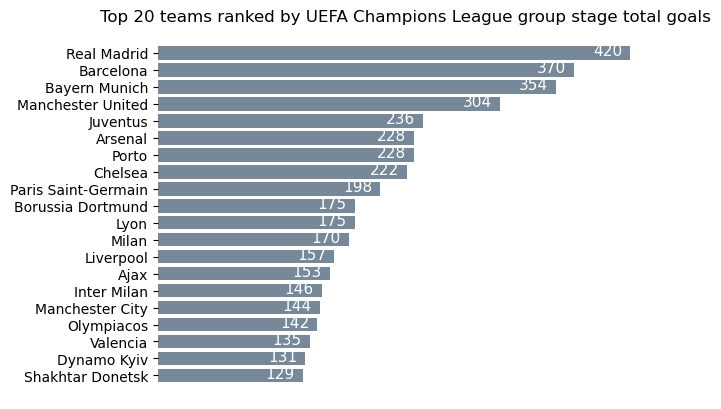

In [204]:
bars = plt.barh( df_bar_chart.index.tolist() [19::-1] , df_bar_chart["GF"].values[19::-1], align='center', linewidth=0, color='lightslategrey'  )

plt.xticks([])
plt.title("Top 20 teams ranked by UEFA Champions League group stage total goals")

for spine in plt.gca().spines.values():
    spine.set_visible(False)

for bar in bars:
    width = bar.get_width()
    plt.gca().text( bar.get_width() - 20, bar.get_y() + bar.get_height() / 2 - 0.15 , str(int(width)),
                   ha='center', color='w', fontsize=11)


Let's look at a bar chart representing the top 20 teams by total points.

In [205]:
df_bar_chart = individual_team_data_df.sort_values("Pts",ascending = False)

df_bar_chart

,W,D,L,GF,GA,GD,Pts
Real Madrid,116,35,29,420,191,229,383
Barcelona,110,40,24,370,155,215,370
Bayern Munich,106,34,28,354,149,205,352
Manchester United,95,40,33,304,153,151,325
Juventus,81,36,27,236,127,109,279
...,...,...,...,...,...,...,...
Debrecen,0,0,6,5,19,-14,0
Oțelul Galați,0,0,6,3,11,-8,0
Levski Sofia,0,0,6,1,17,-16,0
Žilina,0,0,6,3,19,-16,0


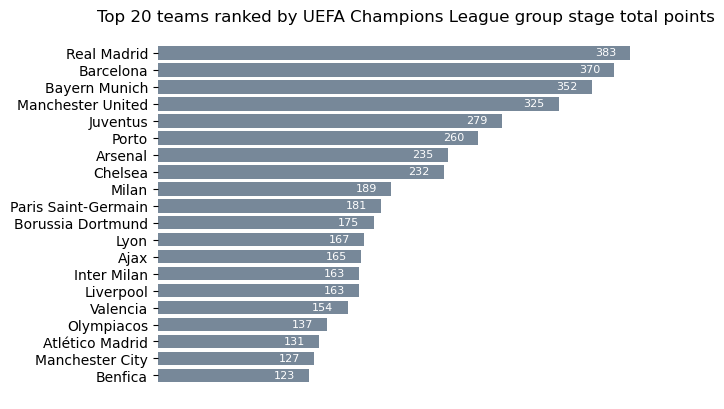

In [206]:
bars = plt.barh( df_bar_chart.index.tolist() [19::-1] , df_bar_chart["Pts"].values[19::-1], align='center', linewidth=0, color='lightslategrey'  )

plt.xticks([])
plt.title("Top 20 teams ranked by UEFA Champions League group stage total points")

for spine in plt.gca().spines.values():
    spine.set_visible(False)

for bar in bars:
    width = bar.get_width()
    plt.gca().text( bar.get_width() - 20, bar.get_y() + bar.get_height() / 2 - 0.15 , str(int(width)),
                   ha='center', color='w', fontsize=8)


Next, we look at a different data set, namely the top 25 accumulative expenditure of transfer fees by clubs from 1992-1993 to 2021-2022 season. The data come from Transfermarkt. We scrape those data using the same method.

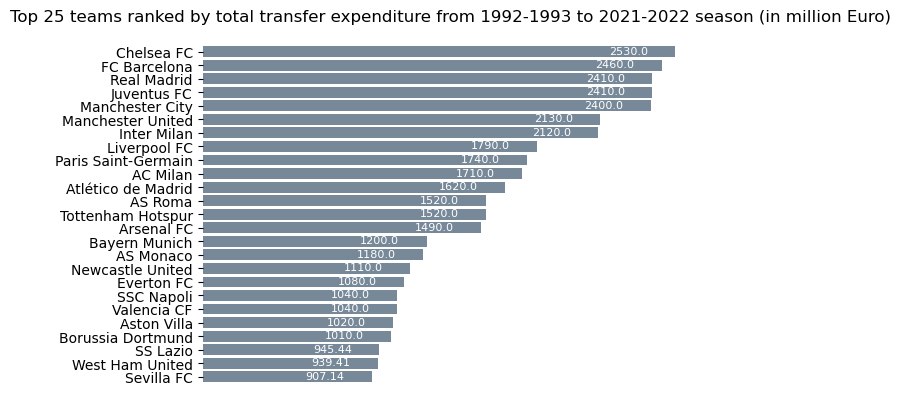

In [207]:
transfer_data_url = "https://www.transfermarkt.us/transfers/einnahmenausgaben/statistik/plus/0?ids=a&sa=&saison_id=1992&saison_id_bis=2021&land_id=&nat=&kontinent_id=&pos=&altersklasse=&w_s=&leihe=&intern=0&plus=0"

transfer_data_table_redundant = BeautifulSoup(open( "Transfer.html" ), "html.parser").find("div", {"id": "yw1"})

top_25_teams_transfer_expenditure = list( map(lambda x: x["title"] , transfer_data_table_redundant.find_all("img" , {"class": "tiny_wappen"}) ) )

top_25_expenditure = list( map(lambda x: x.text , transfer_data_table_redundant.find_all("td" , {"class": "rechts hauptlink redtext"}) ) )

def value_str_to_int(x):
    if x.find("bn")>0 :
        return float( re.findall( "\d+.\d+" , x)[0] ) * 1000
    if x.find("m")>0:
        return float( re.findall( "\d+.\d+" , x)[0] )

top_25_expenditure = list( map(value_str_to_int , top_25_expenditure ))

bars = plt.barh( top_25_teams_transfer_expenditure[::-1] , top_25_expenditure[::-1] , align='center', linewidth=0, color='lightslategrey'  )

plt.xticks([])
plt.title("Top 25 teams ranked by total transfer expenditure from 1992-1993 to 2021-2022 season (in million Euro)")

for spine in plt.gca().spines.values():
    spine.set_visible(False)

for bar in bars:
    width = bar.get_width()
    plt.gca().text( bar.get_width() - 250, bar.get_y() + bar.get_height() / 2 - 0.15 , str(float(width)),
                   ha='center', color='w', fontsize=8)


Our last goal is to compute correlation of the total points of these teams against the total transfer expenditure. But we first have to modify the team names here to match up with our previously constructed data frame. Let's check the difference.

In [208]:
print(sorted(individual_team_data_df.index.tolist()))

set(top_25_teams_transfer_expenditure) - set( individual_team_data_df.index.tolist() )

['1899 Hoffenheim', 'AEK Athens', 'AIK', 'APOEL', 'AZ', 'AaB', 'Aalborg BK', 'Ajax', 'Anderlecht', 'Anorthosis', 'Arsenal', 'Artmedia', 'Astana', 'Atalanta', 'Athletic Bilbao', 'Atlético Madrid', 'Austria Wien', 'Auxerre', 'BATE Borisov', 'Barcelona', 'Basel', 'Bayer Leverkusen', 'Bayern Munich', 'Benfica', 'Beşiktaş', 'Blackburn Rovers', 'Boavista', 'Bordeaux', 'Borussia Dortmund', 'Borussia Mönchengladbach', 'Braga', 'Brøndby', 'Bursaspor', 'CFR Cluj', 'CSKA Moscow', 'Casino Salzburg', 'Celta Vigo', 'Celtic', 'Chelsea', 'Club Brugge', 'Copenhagen', 'Croatia Zagreb', 'Debrecen', 'Deportivo La Coruña', 'Dinamo Zagreb', 'Dynamo Kyiv', 'Fenerbahçe', 'Ferencváros', 'Feyenoord', 'Fiorentina', 'Galatasaray', 'Genk', 'Gent', 'Grasshopper', 'HJK', 'Hajduk Split', 'Hamburg', 'Hapoel Tel Aviv', 'Heerenveen', 'Helsingborg', 'Hertha BSC', 'IFK Göteborg', 'Inter Milan', 'Juventus', 'Kaiserslautern', 'Košice', 'Krasnodar', 'Lazio', 'Leeds United', 'Legia Warsaw', 'Leicester City', 'Lens', 'Levski S

{'AC Milan',
 'AS Monaco',
 'AS Roma',
 'Arsenal FC',
 'Aston Villa',
 'Atlético de Madrid',
 'Chelsea FC',
 'Everton FC',
 'FC Barcelona',
 'Juventus FC',
 'Liverpool FC',
 'SS Lazio',
 'SSC Napoli',
 'Sevilla FC',
 'Valencia CF',
 'West Ham United'}

Note in fact Aston Villa, Everton, West Ham United never played in UEFA Champions League group stage. So we will only consider 22 teams.

In [209]:
top_25_teams_transfer_expenditure_name_replacement = {'AC Milan': 'Milan',
 'AS Monaco': 'Monaco',
 'AS Roma': 'Roma',
 'Arsenal FC': 'Arsenal',
 'Atlético de Madrid': 'Atlético Madrid',
 'Chelsea FC': 'Chelsea',
 'FC Barcelona': 'Barcelona',
 'Juventus FC': 'Juventus',
 'Liverpool FC': 'Liverpool',
 'SS Lazio': 'Lazio',
 'SSC Napoli': 'Napoli',
 'Sevilla FC': 'Sevilla',
 'Valencia CF': 'Valencia'}

top_22_teams_transfer = {}

for i in range(25):
    if top_25_teams_transfer_expenditure[i] not in ['Aston Villa' , 'Everton FC' , 'West Ham United' ]:
        if top_25_teams_transfer_expenditure[i] in top_25_teams_transfer_expenditure_name_replacement.keys():
            top_22_teams_transfer[ top_25_teams_transfer_expenditure_name_replacement[top_25_teams_transfer_expenditure[i]] ] = top_25_expenditure[i]
        else:
            top_22_teams_transfer[top_25_teams_transfer_expenditure[i]] = top_25_expenditure[i]


print(top_22_teams_transfer)
df_top_22_teams_transfer = pd.DataFrame.from_dict(top_22_teams_transfer , orient='index' , columns = ["Total transfer expenditure"] )
df_top_22_teams_transfer    


{'Chelsea': 2530.0, 'Barcelona': 2460.0, 'Real Madrid': 2410.0, 'Juventus': 2410.0, 'Manchester City': 2400.0, 'Manchester United': 2130.0, 'Inter Milan': 2120.0, 'Liverpool': 1790.0, 'Paris Saint-Germain': 1740.0, 'Milan': 1710.0, 'Atlético Madrid': 1620.0, 'Roma': 1520.0, 'Tottenham Hotspur': 1520.0, 'Arsenal': 1490.0, 'Bayern Munich': 1200.0, 'Monaco': 1180.0, 'Newcastle United': 1110.0, 'Napoli': 1040.0, 'Valencia': 1040.0, 'Borussia Dortmund': 1010.0, 'Lazio': 945.44, 'Sevilla': 907.14}


,Total transfer expenditure
Chelsea,2530.00
Barcelona,2460.00
Real Madrid,2410.00
Juventus,2410.00
Manchester City,2400.00
Manchester United,2130.00
Inter Milan,2120.00
Liverpool,1790.00
Paris Saint-Germain,1740.00
Milan,1710.00


We make a join table that contains info about both total transfer expenditure and team performance.

In [210]:
df_top_22_teams_transfer_join = df_top_22_teams_transfer.join( individual_team_data_df , how='inner')

df_top_22_teams_transfer_join 


,Total transfer expenditure,W,D,L,GF,GA,GD,Pts
Chelsea,2530.00,68,28,18,222,80,142,232
Barcelona,2460.00,110,40,24,370,155,215,370
Real Madrid,2410.00,116,35,29,420,191,229,383
Juventus,2410.00,81,36,27,236,127,109,279
Manchester City,2400.00,38,13,15,144,79,65,127
Manchester United,2130.00,95,40,33,304,153,151,325
Inter Milan,2120.00,46,25,25,146,109,37,163
Liverpool,1790.00,46,25,19,157,80,77,163
Paris Saint-Germain,1740.00,55,16,19,198,92,106,181
Milan,1710.00,54,35,31,170,113,57,189


Finally, we make a scatter plot, and compute the correction between points and transfer expenditure.

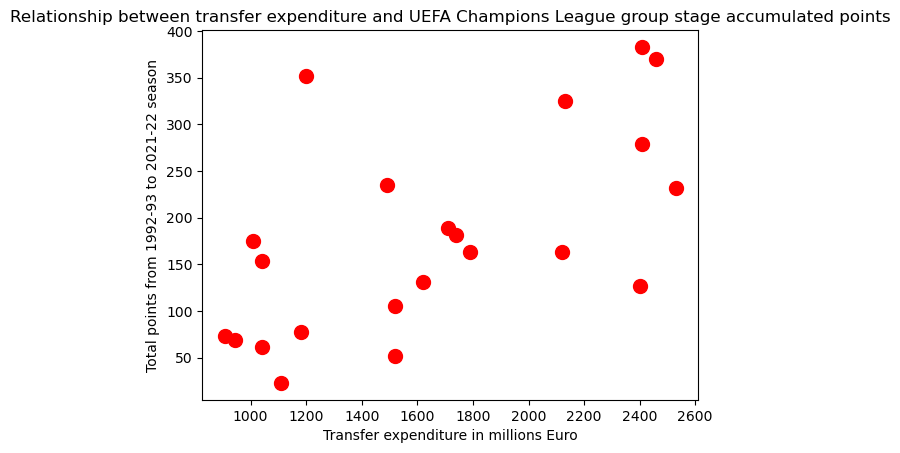

In [211]:
plt.scatter(df_top_22_teams_transfer_join["Total transfer expenditure"], df_top_22_teams_transfer_join["Pts"], s=100, c="red");

plt.xlabel('Transfer expenditure in millions Euro')

plt.ylabel('Total points from 1992-93 to 2021-22 season')

plt.title('Relationship between transfer expenditure and UEFA Champions League group stage accumulated points');


In [212]:
import scipy.stats

scipy.stats.pearsonr(df_top_22_teams_transfer_join["Total transfer expenditure"] , df_top_22_teams_transfer_join["Pts"])

PearsonRResult(statistic=0.6075751125981014, pvalue=0.002707078794201094)

We see that the correlation is pretty high with a low p-value.